# Poisson image editting

## Loading dependencies and sanity checking

(375, 353, 3)
(375, 353, 3)


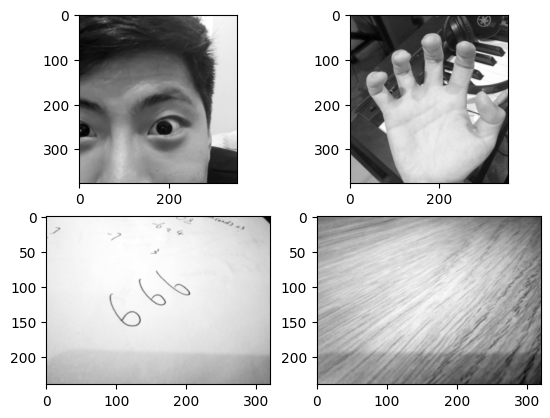

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import scipy.sparse as sparse

def down_scale(img, iter):
    image = np.copy(img)
    for i in range(iter):
        image = cv2.pyrDown(image)
    return image

source_path = "images/eye.jpg"
target_path = "images/hand.jpg"

source_orig = plt.imread(source_path)
target_orig = plt.imread(target_path)
source_orig2 = plt.imread("images/666.jpg")
target_orig2 = plt.imread("images/desk.jpg")
target_orig = target_orig[800:3800,1000:-400]
source_orig = source_orig[1000:4000,1400:]
target = down_scale(target_orig,3)
source = down_scale(source_orig,3)
target2 = down_scale(target_orig2,4)
source2 = down_scale(source_orig2,4)
print(source.shape)
print(target.shape)
gray_source = cv2.cvtColor(source, cv2.COLOR_RGB2GRAY).astype(np.float32)
gray_target = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY).astype(np.float32)
gray_source2 = cv2.cvtColor(source2, cv2.COLOR_RGB2GRAY).astype(np.float32)
gray_target2 = cv2.cvtColor(target2, cv2.COLOR_RGB2GRAY).astype(np.float32)
plt.subplot(2, 2, 1)
plt.imshow(gray_source, "gray")
plt.subplot(2, 2, 2)
plt.imshow(gray_target,"gray")
plt.subplot(2, 2, 3)
plt.imshow(gray_source2, "gray")
plt.subplot(2, 2, 4)
plt.imshow(gray_target2,"gray")


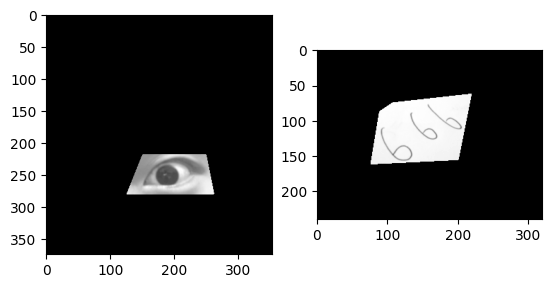

In [2]:
mask = np.zeros_like(source_orig[:,:,0])
mask_edge = np.zeros_like(source_orig[:,:,0])
mask_middle = np.zeros_like(source_orig[:,:,0])
mask_large = np.zeros_like(source_orig[:,:,0])
mask_6 = np.zeros_like(source_orig2[:,:,0])
corners = np.array([[1750,1200],[1750,2000],[2250,2100],[2250,1000]])
corners_edge = np.array([[1100,250],[1800,250],[1800,750],[1100,750]])
corners_middle = np.array([[600,250],[2000,250],[2000,1100],[600,1100]])
corners_large = np.array([[500,200],[2200,200],[2200,2000],[500,2000]])
corners = corners[:,[1,0]] # actual corner used is by numpy axis
corners_6 = np.array([[1700,1200],[3500,1000],[3200,2500],[1200,2600],[1400,1400]])
cv2.fillConvexPoly(mask, corners, 1)
cv2.fillConvexPoly(mask_edge, corners_edge, 1)
cv2.fillConvexPoly(mask_middle, corners_middle, 1)
cv2.fillConvexPoly(mask_large, corners_large, 1)
cv2.fillConvexPoly(mask_6, corners_6, 1)
mask = down_scale(mask,3)
mask = mask.astype(int)
mask_edge = down_scale(mask_edge,3)
mask_edge = mask_edge.astype(int)
mask_middle = down_scale(mask_middle,3)
mask_middle = mask_middle.astype(int)
mask_large = down_scale(mask_large,3)
mask_large = mask_large.astype(int)
mask_6 = down_scale(mask_6,4)
mask_6 = mask_6.astype(int)
plt.subplot(1, 2, 1)
plt.imshow(mask*gray_source,"gray")
plt.subplot(1, 2, 2)
plt.imshow(mask_6*gray_source2,"gray")

## Task1

### Get different masks

In [3]:
def grad_neighbor(index):
    x,y = index
    return np.array([[x-1,y],[x+1,y],[x,y-1],[x,y+1]])

def edge(index, mask):
    "check if a point is on edge"
    indicies = grad_neighbor(index)
    x = np.clip(indicies[:,0],0,mask.shape[0]-1)
    y = np.clip(indicies[:,1],0,mask.shape[1]-1)
    return np.any(mask[x,y] == 1) and ~np.all(mask[x,y] == 1)

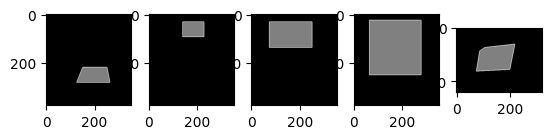

In [4]:
# Showing the mask with edge highlighted
def gen_edge_mask(mask):
    edge_mask = np.copy(mask)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if edge((x,y),mask=mask):
                edge_mask[x,y] = 2
    return edge_mask
edge_mask = gen_edge_mask(mask)
edge_mask_edge = gen_edge_mask(mask_edge)
edge_mask_middle = gen_edge_mask(mask_middle)
edge_mask_large = gen_edge_mask(mask_large)
edge_mask_6 = gen_edge_mask(mask_6)

plt.subplot(1, 5, 1)
plt.imshow(edge_mask,"gray")
plt.subplot(1, 5, 2)
plt.imshow(edge_mask_edge,"gray")
plt.subplot(1, 5, 3)
plt.imshow(edge_mask_middle,"gray")
plt.subplot(1, 5, 4)
plt.imshow(edge_mask_large,"gray")
plt.subplot(1, 5, 5)
plt.imshow(edge_mask_6,"gray")

### Generate A and b

In [5]:
def grad_neighbor_vec(index):
    """
    vectorized get neighbor
    """
    x,y = index[...,0], index[...,1]
    return np.array([[x-1,y],[x+1,y],[x,y-1],[x,y+1]])

# Create the sparse matrix
def sparse_matrix_loop(points):
    """
    points: indicies for which the intensity need to be solved (Nx2)
    """
    N = len(points)
    A = sparse.lil_matrix((N,N))
    for i,index in enumerate(points):
        if i%100 == 0:
            print(i, " / ", N)
        A[i,i] = 4
        j = np.where((points == grad_neighbor(index)[:,None]).all(-1))[1]
        A[i,j] = -1
    return A.tocsr()

def sparse_matrix(points):
    """
    points: indicies for which the intensity need to be solved (Nx2) vectorized
    """
    N = len(points)
    # print(N)
    # diagonal is 4
    diagonal = np.full(N, 4)
    diag = sparse.diags(diagonal, format="csr")
    # get neighbor index in points for each point in points
    # print(points)
    # compare coordinates in points and each neighbor to get index in a vectorized way
    nei = grad_neighbor_vec(points)
    nei = np.transpose(nei,axes=[2,0,1])
    # print(nei[0])
    ind = np.where((points[:,None] == nei[:,None]).all(-1))
    a, b = ind[0], ind[1]
    # print(a,b)
    data = -np.ones(len(a))
    mat = sparse.csr_array((data, (a, b)), shape=(N,N))
    A = diag + mat
    return A

def get_target_grad(target, points, edge_mask):
    N = len(points)
    b = np.zeros(N)
    for i,index in enumerate(points):
        if edge_mask[index[...,0],index[...,1]] == 2:
            for pt in grad_neighbor(index):
                if edge_mask[pt[...,0],pt[...,1]] < 1:
                    b[i] += target[pt[...,0],pt[...,1]]
    return np.copy(b)

def get_blended(edge_mask, gray_target):
    points = np.column_stack(np.nonzero(edge_mask))
    print("building A")
    A = sparse_matrix(points)
    print("building b")
    b = get_target_grad(gray_target, points, edge_mask)
    x = sparse.linalg.spsolve(A, b)
    out = np.copy(gray_target)
    out[points[...,0],points[...,1]] = x
    return out

### Solve for x to fill in the masked area
After down_scaling:

Middle mask task around 15s, 
Large mask takes around 4 mins comment the larger mask if nessesary

In [6]:
eq2_smooth = get_blended(edge_mask, gray_target)

eq2_edge = get_blended(edge_mask_edge, gray_target)

eq2_middle = get_blended(edge_mask_middle, gray_target)

eq2_large = get_blended(edge_mask_large, gray_target)

building A
building b
building A
building b
building A
building b
building A
building b


Displaying the different masked blended regions with equation 2. 

The first image blends the smooth regions, since the signal is already smooth, can not spot a big difference.

The second image shows the small regions covering sharp edges. As the change of gradient need to be 0 and the edges(of the mask) need to be the same value as target, we can see that the masked region becomes noticably blurry.

The third and fourth image shows larger regions. As the regions grows larger, the gradient in the regions should be small because a bigger area is provided to blend between the edges of the mask. This is shown by a less drastic change in the masked region. However as more edges are covered by the larger mask, the image get more blurry with less details.

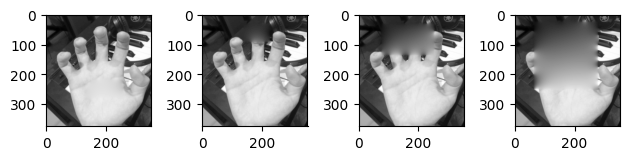

In [7]:
plt.subplot(1, 4, 1)
plt.imshow(eq2_smooth,"gray")
plt.subplot(1, 4, 2)
plt.imshow(eq2_edge,"gray")
plt.subplot(1, 4, 3)
plt.imshow(eq2_middle,"gray")
plt.subplot(1, 4, 4)
plt.imshow(eq2_large,"gray")
plt.tight_layout()

## Task2(a):

In [8]:
# Borrowed apply filter from lab
def apply_filter(src_img, kernel):
    assert len(src_img.shape) == 2, print("Dimension mismatch! Please supply gray-scale image only!")
    assert len(kernel.shape) == 2, print("Dimension mismatch! Please supply 2D kernel only!")
    # code here
    kh, kw = kernel.shape
    # kernel = np.pad(kernel, ((x, H-kh-x), (y, W-kw-y)), 'constant')
    fft_im = np.fft.fft2(src_img, src_img.shape)
    fft_k  = np.fft.fft2(kernel, src_img.shape)
    fft_out = fft_k * fft_im
    denoised_image = np.real(np.fft.ifft2(fft_out))
    return np.roll(np.roll(denoised_image, -(kh-1)//2, axis=0), -(kw-1)//2, axis=1)

def get_lap_kernel():
    lap = np.array([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]])
    return lap

def import_grad(source, points):
    N = len(points)
    b = np.zeros(N)
    grad_b = apply_filter(source, get_lap_kernel())
    b = grad_b[points[...,0],points[...,1]]
    return b

def get_import_grad_blended(edge_mask, gray_target, gray_source):
    """
    Added the gradient of source image
    """
    points = np.column_stack(np.nonzero(edge_mask))
    print("building A")
    A = sparse_matrix(points)
    print("building b")
    b = get_target_grad(gray_target, points, edge_mask)
    b += import_grad(gray_source, points)
    x = sparse.linalg.spsolve(A, b)
    out = np.copy(gray_target)
    out[points[...,0],points[...,1]] = x
    return out

building A
building b
building A
building b


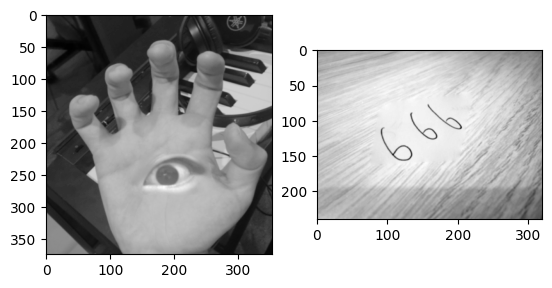

In [9]:
import_blend = get_import_grad_blended(edge_mask, gray_target, gray_source)
import_blend2 = get_import_grad_blended(edge_mask_6, gray_target2, gray_source2)
plt.subplot(1, 2, 1)
plt.imshow(import_blend,"gray")
plt.subplot(1, 2, 2)
plt.imshow(import_blend2,"gray")

## Task2(b):

In [10]:
# borrowed from lab
def get_prewitt_kernel():
    Kx = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])
    
    Ky = np.array([[-1,-1,-1],
                   [0, 0, 0],
                   [1, 1, 1]])
    return Kx, Ky

def get_grad(gray_img):
    Kx, Ky = get_prewitt_kernel()
    Gx, Gy = apply_filter(gray_img, Kx), apply_filter(gray_img, Ky)
    G_prewitt = np.sqrt(Gx**2 + Gy**2)
    return G_prewitt


def vpq(gray_source, gray_target, index):
    """
    Decide whether to take s or t's gradient at each dir
    """
    i,j = index
    up_t = gray_target[i,j] - gray_target[i+1, j]
    down_t = gray_target[i,j] - gray_target[i-1, j]
    left_t = gray_target[i,j] - gray_target[i, j-1]
    right_t = gray_target[i,j] - gray_target[i, j+1]
    up = gray_source[i,j] - gray_source[i+1, j]
    down = gray_source[i,j] - gray_source[i-1, j]
    left = gray_source[i,j] - gray_source[i, j-1]
    right = gray_source[i,j] - gray_source[i, j+1]
    up = up_t if abs(up_t) > abs(up) else up
    down = down_t if abs(down_t) > abs(down) else down
    left = left_t if abs(left_t) > abs(left) else left
    right = right_t if abs(right_t) > abs(right) else right
    return up+down+left+right

def get_mixed_grad(gray_source, gray_target, points, edge_mask):
    grad_t = apply_filter(gray_target, get_lap_kernel())
    grad_b = apply_filter(gray_source, get_lap_kernel())
    N = len(points)
    b = np.zeros(N)
    for i,index in enumerate(points):
        b[i] = vpq(gray_source, gray_target, index)
        if edge_mask[index[...,0],index[...,1]] == 2:
            for pt in grad_neighbor(index):
                if edge_mask[pt[...,0],pt[...,1]] < 1:
                    b[i] += gray_target[pt[...,0],pt[...,1]]
    return np.copy(b)


def get_mix_grad_blended(edge_mask, gray_target, gray_source):
    """
    Added the gradient of source image
    """
    points = np.column_stack(np.nonzero(edge_mask))
    print("building A")
    A = sparse_matrix(points)
    print("building b")
    b = get_mixed_grad(gray_source, gray_target, points, edge_mask)
    x = sparse.linalg.spsolve(A, b)
    out = np.copy(gray_target)
    out[points[...,0],points[...,1]] = x
    return out

building A
building b
building A
building b


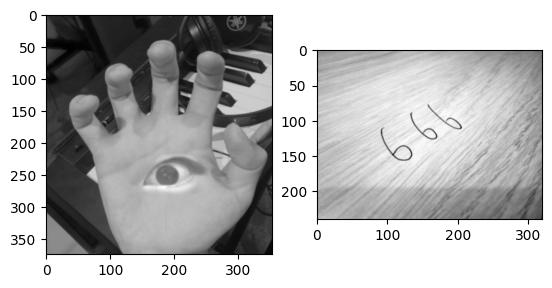

In [11]:
mix_blend = get_mix_grad_blended(edge_mask, gray_target, gray_source)
mix_blend2 = get_mix_grad_blended(edge_mask_6, gray_target2, gray_source2)
plt.subplot(1, 2, 1)
plt.imshow(mix_blend,"gray")
plt.subplot(1, 2, 2)
plt.imshow(mix_blend2,"gray")

## Task3:

In [12]:
def get_import_grad_color_blended(edge_mask, target, source):
    """
    For RGB channels
    """
    points = np.column_stack(np.nonzero(edge_mask))
    print("building A")
    A = sparse_matrix(points)
    print("building b")
    channels = 3
    out = np.copy(target).astype(np.float32)
    for i in range(channels):
        target_chan = target[:,:,i].astype(np.float32)
        source_chan = source[:,:,i].astype(np.float32)
        b = get_target_grad(target_chan, points, edge_mask)
        b += import_grad(source_chan, points)
        x = sparse.linalg.spsolve(A, b)
        out[points[...,0],points[...,1],i] = x
    return out

import_blend_colored = get_import_grad_color_blended(edge_mask, target, source)

building A
building b


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


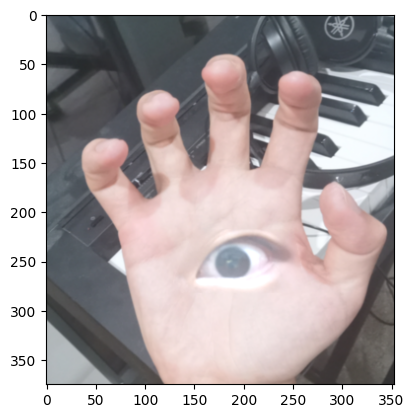

In [13]:
plt.imshow(import_blend_colored.astype(int))

## Task4:
Local color change

In [14]:
image_orig = plt.imread("images/colors.jpg")

image = down_scale(image_orig, 2)
gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY).astype(np.float32)
luminance = cv2.cvtColor(gray_image,cv2.COLOR_GRAY2RGB).astype(int)

# corners = np.array([[1500,20],[1400,400],[1530,250],[1600,550],[1500,900]]) not convex
corners = np.array([[1500,20], [1600,550],[1500,900],[960,1000],[850,450], [1100,210]])
mask = np.zeros_like(image_orig[:,:,0])
cv2.fillConvexPoly(mask, corners, 1)
mask = down_scale(mask, 2)
edge_mask = gen_edge_mask(mask)


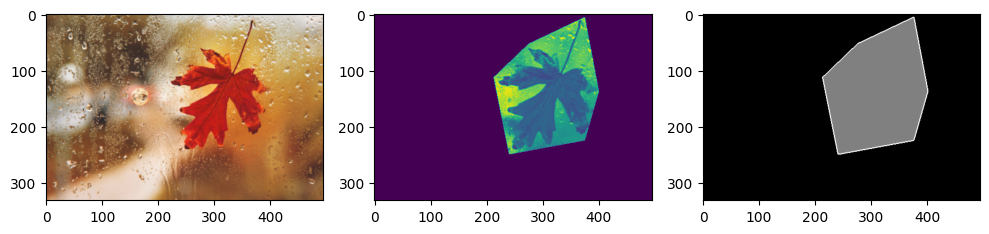

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(mask*gray_image)
plt.subplot(1, 3, 3)
plt.imshow(edge_mask,"gray")
plt.tight_layout()

building A
building b


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


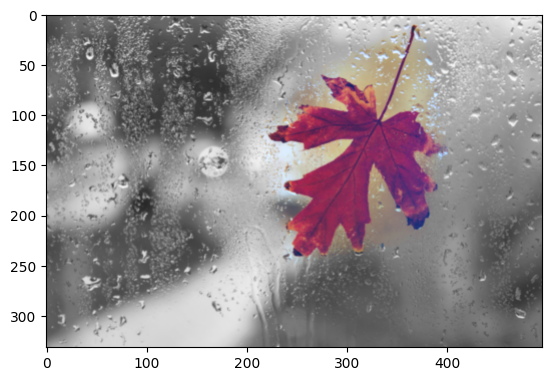

In [16]:
target = luminance
source = image
import_blend_colored = get_import_grad_color_blended(edge_mask, target, source)
plt.imshow(import_blend_colored.astype(int))